Notebook 6: Principal Component Analysis (PCA)
==============================================

## Goals for learning
In this assignment, we will:
1) Perform a deep-dive into the **Principal Component Analysis** (PCA) dimensionality reduction algorithm.
2) Practice working with the array-oriented programming paradigm.
3) Gain experience working with off-the-shelf machine learning and data analysis libraries.

## Instructions
* Read through the notebook.
* Answer any plain text questions (replace cell content, "YOUR RESPONSE HERE", with your response).
* Insert your code within the code blocks marked with the comments "# START your code here" and "# STOP your code here".
* Do not use loops, iteration, or recursion in any of the code cells (except where explicitly allowed).
* Do not use any "Generative AI" tools or assistants in the creation of your solutions.
* Do not import ot use any libraries other than those already imported outside the "# START your code here" and "# STOP your code here" blocks.
    * **In some blocks, you are not allowed to use certain numpy and pandas methods. Please pay attention to the "TO DO" instructions.**
* Run all cells to make sure your code works and you see reasonable results.
    * All code cells should have output indicating the results of the last run when the notebook is submitted.
    * If there are errors, or if a code cell does not have output as submittted, points will be deducted.

## Submission details
* Due: Monday 10/27, 11:59 PM
* [Submission instructions](https://www.cs.oswego.edu/~agraci2/csc461/submission_instructions.html)

## Notebook premise
You are an ML engineer working at a real estate company. Your company wants to develop a dataset with lower dimensionality that retains as much information as possible from the original dataset while bringing compute times down and improving the performance of distance-based algorithms.

Another team has already done some **[feature selection](https://en.wikipedia.org/wiki/Feature_selection)** on the original dataset for a different project, now your team is tasked with getting the number of dimensions down even further.

After some research, your team determines that the best solution would be to implement the **[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)** (PCA) algorithm and apply it to your data.

## Loading the data
This project uses data from [House Sales in King County, USA](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction) to perform training and evaluation

In [1]:
# START your code here
# Path where you downloaded the training and test data
DATA_PATH = ''
# STOP your code here

In [2]:
import numpy as np
import pandas as pd
import os

# Read in the database
HOUSING_DATA_FILENAME = "kc_house_data.csv"
assert os.path.isfile(os.path.join(DATA_PATH, HOUSING_DATA_FILENAME)), "Could not find database file at: {}".format(DATA_PATH)
house_df = pd.read_csv(os.path.join(DATA_PATH, HOUSING_DATA_FILENAME))

# Apply the previous "feature selection"
dataframe = house_df[['price', 'bedrooms', 'sqft_lot', 'yr_built', 'floors', 'sqft_living']]

## Scaling the data
Looking at your data, you notice that some of the features are on a much larger scale than others. 
You decide to use the **z-score** of each feature, which centers the data around 0 and imposes a standard deviation of 1.

$$ z(X) = {(X - \mu_X) \over {\sigma}} $$

In [3]:
def ScaleData(df):
    
    '''
    TO DO:
    Scale the data using the equation above.
    Store the results in the mutible dataframe (df)
    '''
    # START your code here
    mu = df.mean()
    std = df.std()
    zscore = (df-mu)/std
    df = zscore
    # STOP your code here
    
    return df

checkpoint_df = ScaleData(dataframe)
print(checkpoint_df.shape)
assert checkpoint_df.shape == (21613, 6), "Incorrect shape: {}".format(checkpoint_df.shape())

(21613, 6)


You decide to check your work by plotting the variances of the original data vs. those of the scaled data. 

$$ \text{VAR}(X) = {\sum_{i=0}^{N,samples}{(X_i - \mu_X)^2} \over {N-1}} $$

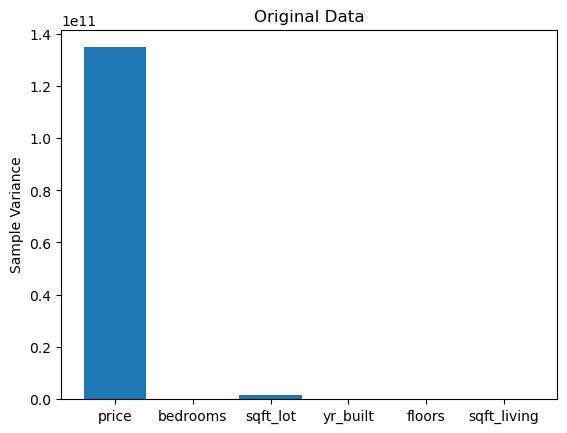

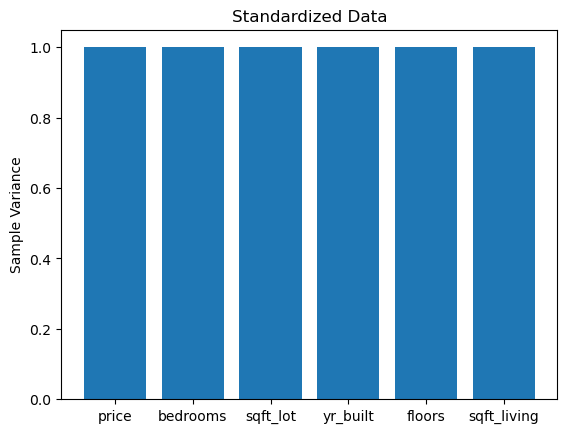

In [4]:
import matplotlib.pyplot as plt

# Compute the variance of each feature if the dataframe
def var(df):
    variance = None
    
    '''
    TO DO:
    Compute the sample variance for feature X.
    DO NOT use the built-in "var()" method (or equivalent) from numpy, pandas, or sklearn
    '''
    # START your code here
    variance = df.std() ** 2
    # STOP your code here
    
    return variance
    
# Variance checkpoint
checkpoint_variances = var(dataframe)
checkpoint_variances_truth = dataframe.var()
assert checkpoint_variances.shape == checkpoint_variances_truth.shape
assert np.allclose(checkpoint_variances, checkpoint_variances_truth), "Invalid variances: \n {} \n vs. \n {}".format(checkpoint_variances, checkpoint_variances_truth)
    
# Plot the variances of each feature in a dataset
def PlotVariance(df, title):
    variances = var(df) # Use your variance function!
    features = variances.keys().values.tolist()
    values = variances.values.tolist()

    fig, ax = plt.subplots()
    ax.bar(features, values, label=features)
    ax.set_ylabel('Sample Variance')
    ax.set_title(title)
    plt.show()

# Show the original variance
PlotVariance(dataframe, "Original Data")

# Show the standardized variance
PlotVariance(checkpoint_df, "Standardized Data")

##### **Question:** What is the purpose of scaling your data? What would you expect to happen if you did not scale the data?

##### **Question:** In the original dataset, are there any features whose impact you expect to be over-represented in your calculations? Which one(s)?

##### **Question:** In the scaled dataset, are there any features whose impact you expect to be over-represented in your calculations? Which one(s)?

## Computing the Covariance Matrix
Next, you want to compute the **[Covariance Matrix](https://en.wikipedia.org/wiki/Covariance_matrix)** for your scaled data. When doing this, we will use the **[unbiased](https://math.oxford.emory.edu/site/math117/besselCorrection/)** (or "sample") Covariances: 

$$ \text{COV}(X, Y) = {\sum_{i=0}^{N,samples}{(X_i - \mu_X)(Y_i - \mu_Y)} \over {N - 1}} $$

Where X and Y are features.

In [5]:
# Compute an unbiased covariance for two features X and Y
def ComputeCovariance(X, Y):
    assert X.shape[0] == Y.shape[0]
    cov = None
    
    '''
    TO DO:
    - Compute the sample covariance for features X and Y.
    - DO NOT use the built-in numpy, pandas, or sklearn covariance functions
    '''
    # START your code here
    N = X.shape[0]
    cov = np.sum((X-X.mean()) * (Y-Y.mean()))/(N - 1)
    # STOP your code here
    
    return cov

checkpoint_cov = ComputeCovariance(checkpoint_df['price'],checkpoint_df['yr_built'])
checkpoint_cov_truth = np.cov(checkpoint_df['price'],checkpoint_df['yr_built'])[0,1]
assert abs(checkpoint_cov - checkpoint_cov_truth) < 0.0000001, "Incorrect covariance: {}".format(checkpoint_cov)
print("Passed checkpoint.")

Passed checkpoint.


In [6]:
# Compute an entire covariance matrix
def CovarianceMatrix(df):
    dimensionality = df.shape[1]
    C = np.zeros((dimensionality,dimensionality))
    
    '''
    TO DO:
    - Fill out the covariance matrix (C) with the correct data
    - You MAY use iteration for this code block
    - DO NOT compute more covariances than necessary. Use the fact that a covariance matrix is *symmetric*.
    '''
    # START your code here
    for i in range(dimensionality):
        for j in range(i, dimensionality):
            temp = ComputeCovariance(df.iloc[:, i],df.iloc[:, j])
            C[i,j] = temp
            C[j,i] = temp
    # STOP your code here
    
    return C

def CheckpointCovarianceMatrix(checkpoint_cov_mat):
    from sklearn.decomposition import PCA
    checkpoint_cov_mat_truth = PCA().fit(checkpoint_df).get_covariance()
    assert np.allclose(checkpoint_cov_mat, checkpoint_cov_mat_truth), "Invalid covariance matrix: \n {} \n vs. \n {}".format(checkpoint_cov_mat, checkpoint_cov_mat_truth)
    print("Passed checkpoint.")
checkpoint_cov_mat = CovarianceMatrix(checkpoint_df)
CheckpointCovarianceMatrix(checkpoint_cov_mat)

Passed checkpoint.


Now, let's take a look at the resulting covariance matrix.

In [7]:
print("Features: {}".format(checkpoint_df.keys().values.tolist()))
np.set_printoptions(precision=4)

print("\nCovariance matrix (unscaled):")
print(CovarianceMatrix(dataframe))
print(type(CovarianceMatrix(dataframe)))

print("\nCovariance matrix (scaled):")
print(CovarianceMatrix(checkpoint_df))

Features: ['price', 'bedrooms', 'sqft_lot', 'yr_built', 'floors', 'sqft_living']

Covariance matrix (unscaled):
[[ 1.3478e+11  1.0529e+05  1.3634e+09  5.8245e+05  5.0908e+04  2.3672e+08]
 [ 1.0529e+05  8.6502e-01  1.2213e+03  4.2120e+00  8.8104e-02  4.9260e+02]
 [ 1.3634e+09  1.2213e+03  1.7157e+09  6.4581e+04 -1.1633e+02  6.5747e+06]
 [ 5.8245e+05  4.2120e+00  6.4581e+04  8.6280e+02  7.7612e+00  8.5802e+03]
 [ 5.0908e+04  8.8104e-02 -1.1633e+02  7.7612e+00  2.9159e-01  1.7554e+02]
 [ 2.3672e+08  4.9260e+02  6.5747e+06  8.5802e+03  1.7554e+02  8.4353e+05]]
<class 'numpy.ndarray'>

Covariance matrix (scaled):
[[ 1.      0.3083  0.0897  0.054   0.2568  0.702 ]
 [ 0.3083  1.      0.0317  0.1542  0.1754  0.5767]
 [ 0.0897  0.0317  1.      0.0531 -0.0052  0.1728]
 [ 0.054   0.1542  0.0531  1.      0.4893  0.318 ]
 [ 0.2568  0.1754 -0.0052  0.4893  1.      0.3539]
 [ 0.702   0.5767  0.1728  0.318   0.3539  1.    ]]


##### **Question:** Can you give one example of two features that are **positively** correlated? Name them.

##### **Question:** Can you give one example of two features that are **negatively** correlated? Name them.

## Eigenvalues and Eigenvectors

In this step, we determine our **principal components** by manipulating **[eigenvalues and eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors)** of our covariance matrix.

You remember from your ML class that **eigenvectors** can be used to determine the **directions** in which the data "stretches" and that the corresponding **eigenvalues** can tell you **how much** the data stretches in those directions.

Fortunately, someone at your company has already implemented functions to determine eigenvalues and eigenvectors from a covariance matrix!

<u>Note</u>: Eigenvalues and eigenvectors have many uses outside of PCA. This is one of those areas where taking a good matrix algebra course would be very enriching.

In [8]:
# Treat this as the existing implementation at your company that you can re-use
# - Input: a covariance matrix
# - Outputs: 
#    - w: An array of eigenvalues
#    - v: An array of eigenvectors
def GetEigen(covariance_matrix):
    from numpy.linalg import eig
    return eig(covariance_matrix)

# Example usage
w,v=GetEigen(checkpoint_cov_mat)
print('Eigenvalues:', w)
print('Eigenvectors: \n', v)

Eigenvalues: [2.4325 0.1879 0.4738 0.7243 1.196  0.9855]
Eigenvectors: 
 [[-0.4638 -0.529   0.1818  0.5693  0.3653 -0.1202]
 [-0.4188 -0.3    -0.2687 -0.7403  0.2446 -0.2336]
 [-0.119  -0.0766 -0.1498 -0.0695  0.2327  0.9479]
 [-0.3286 -0.2201  0.5923 -0.2094 -0.646   0.1778]
 [-0.3894  0.0338 -0.6915  0.2803 -0.539  -0.0025]
 [-0.5794  0.7581  0.2082  0.024   0.2117 -0.0288]]


In principal component analysis, we want to find the principal components with the greatest variance (where data "stretches" the farthest). Fortunately, we can get this information from our **eigenvalues**. 

You can think of each principal component as corresponding to one of the **eigenvalues** and one of the **columns** (axis=1) of the **eigenvectors**. A principal component with a **larger eigenvalue** will have a **greater variance**.

In [9]:
# Use eigenvalues and eigenvectors to get all principal components
def GetFeatureVectors(cov_mat):
    reordered_v = None
    
    '''
    TO DO:
    - Get the eigenvalues and eigenvectors from the covariance matrix
    - Order the eigenvalues high to low
    - Reorder the eigenvector columns by their corresponding eigenvalues
    '''
    # START your code here
    w,v = GetEigen(cov_mat)
    
    # https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
    idx = np.argsort(w)[::-1]

    w = w[idx]
    reordered_v = v[:, idx] # :, columns
    # STOP your code here
    
    return reordered_v

feature_vectors = GetFeatureVectors(checkpoint_cov_mat)
# print(feature_vectors.shape, '\n', checkpoint_cov_mat.shape)
assert feature_vectors.shape == checkpoint_cov_mat.shape

## Reducing the Dimensionality
Now we have our principal components defined and they are in order form the one with the highest variance to the one with the lowest variance. Unfortunately, the number of new features is the same as the number of original features in the data set,  so we still have the same dimensionality.

This is the part where we can **reduce the dimensionality** while preserving as much variance as possible.

In the cell below, implement a function to return the subset of N features where the variance is the greatest.

<u>Implementation Hint</u>: Each feature corresponds to a **column** vector (axis=1).
For example, here is a 4x4 matrix where the third column is set to ones:
```
[[0,0,1,0],
 [0,0,1,0],
 [0,0,1,0],
 [0,0,1,0]]
```

In [10]:
# Return the subset of feature vectors with the largest variance
def GetSubsetFeatureVectors(feature_vectors, N):
    subset = None
    
    '''
    TO DO:
    Return the subset of N features.
    '''
    # START your code here
    subset = feature_vectors[:, :N]
    # STOP your code here
    
    return subset

checkpoint_feature_vectors = GetSubsetFeatureVectors(feature_vectors, 4)
# print(checkpoint_feature_vectors.shape)
assert checkpoint_feature_vectors.shape == (6,4)

We can apply the definitions of these new features to our scaled dataset, which gives us our transformed data set with reduced dimensionality.

In order to do this, we apply the following transformation:
    
$$ \text{TransformedData} = \text{FeatureVectors}^T \cdot \text{ScaledData}^T $$

Our goal is to get a **transformed dataset** in the shape (num_rows, N) from our **new features** (num_columns, N) and **scaled data** (num_rows, num_columns) where:

* num_rows: The original number of samples in the dataset
* num_columns: The number of original features in the dataset
* N: The desired number of features (N <= num_columns)

<u>Implementation Hints</u>:

1) For "$X^T$", use the [Dataframe.transpose()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html) operation.
    * View some examples of [transpose matrices](https://en.wikipedia.org/wiki/Transpose).
    * Pay close attention to the shapes of the matrices and what shape we want to have returned to us.
2) For "$X \cdot Y$", use the [Dataframe.dot()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dot.html) operation.
    * This will perform [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication) on our FeatureVectors and ScaledData.
    * Make sure your matrices are the right shape. We want: (N, num_rows) = (N, num_columns) * (num_columns, num_rows)
    * Then we take the transpose of (N, num_rows) to get (num_rows, N) -- this is done for you.

In [11]:
# Transform your scaled data so that it is in terms of the principal components
def TransformData(df, feature_vectors):
    transformed = None
    
    '''
    TO DO:
    - Calculate the transformed data: feature_vectors^T * df^T
    - DO NOT use built-in scikitlearn PCA functions
    '''
    # START your code here
    transformed = feature_vectors.transpose().dot(df.transpose())
    # STOP your code here

    return transformed.transpose()

def CheckpointTransformedData(checkpoint_transformed):
    from sklearn.decomposition import PCA
    checkpoint_transformed_truth = PCA(n_components=4).fit(checkpoint_df).transform(checkpoint_df)
    assert checkpoint_transformed.shape == checkpoint_transformed_truth.shape
    assert np.allclose(np.abs(checkpoint_transformed), np.abs(checkpoint_transformed_truth))
    print("Passed checkpoint.")
checkpoint_transformed = TransformData(checkpoint_df, checkpoint_feature_vectors)
CheckpointTransformedData(checkpoint_transformed)

Passed checkpoint.


## Putting it all together
In the cell below, write a function that puts together all of the previous steps in this notebook to perform principal component analysis.

Passed checkpoint.

See the variance for all of the original features:


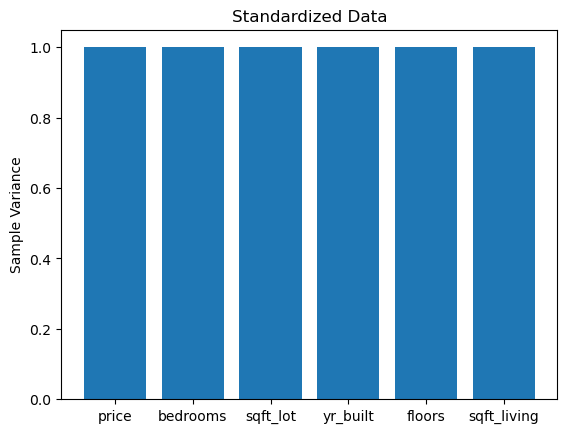

See the variance  for all of the new features (Principal Components):


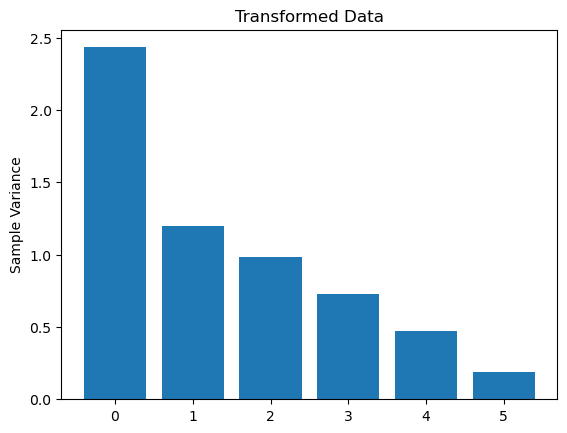

Shape of original data: (21613, 6)
Shape of transformed data: (21613, 2)

Variance after dimensionality reduction to 2 dimensions (no PCA): 2.000000000000137
Variance after dimensionality reduction to 2 dimensions (with PCA): 5.999999999999606


In [14]:
def ComputePCA(df, N):
    pca_data = None
    
    '''
    TO DO:
    1) Scale your data
    2) Compute covariance matrix
    3) Get all principal components
    4) Filter down to the desired number of features
    5) Transform your scaled data using the new features
    '''
    # START your code here
    tmpDF = ScaleData(df)
    matrix = CovarianceMatrix(tmpDF)
    PCs = GetFeatureVectors(matrix)
    filteredPCs = GetSubsetFeatureVectors(PCs, N)
    pca_data = TransformData(tmpDF, filteredPCs)
    # STOP your code here
    
    return pca_data

def CheckpointPCA(checkpoint_pca):
    from sklearn.decomposition import PCA
    checkpoint_pca_truth = PCA(n_components=2).fit(dataframe).transform(dataframe)
    assert checkpoint_pca.shape == (dataframe.shape[0], 2)
    print("Passed checkpoint.")
checkpoint_pca = ComputePCA(dataframe, 2)
CheckpointPCA(checkpoint_pca)

# Show the standardized variance
print("\nSee the variance for all of the original features:")
PlotVariance(checkpoint_df, "Standardized Data")

# Show the transformed variance
print("See the variance  for all of the new features (Principal Components):")
transform_all = ComputePCA(dataframe, dataframe.shape[1])
transformed_subset = pd.DataFrame(transform_all)
PlotVariance(transformed_subset, "Transformed Data")

print("Shape of original data: {}".format(dataframe.shape))
print("Shape of transformed data: {}\n".format(checkpoint_pca.shape))

# Compare the variance retained after dimensionality reduction
scaled_subset = checkpoint_df[['price', 'bedrooms']]
print("Variance after dimensionality reduction to 2 dimensions (no PCA): {}".format(var(scaled_subset).sum()))
print("Variance after dimensionality reduction to 2 dimensions (with PCA): {}".format(var(transformed_subset).sum()))

##### **Question:** How much variance was preserved by using PCA, rather than feature selection when going from 6 dimensions to 2?

Congratulations, you have reached the end of this notebook!